<h1 style="color:rgb(0,120,170)">Neural Networks -- Vanishing Gradient</h1>
<h2 style="color:rgb(0,120,170)">OEAW Machine Learning Summer School 2019</h2>

This notebook is a visualization of the famous Vanishing Gradient problem. It should foster your understanding of what happens to the weights in the different layers. If you want to further stretch the topic you can try to implement different activation functions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1,
                       lr=0.01, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

torch.Size([60000])
torch.Size([60000, 28, 28])
Input dimension is 784.


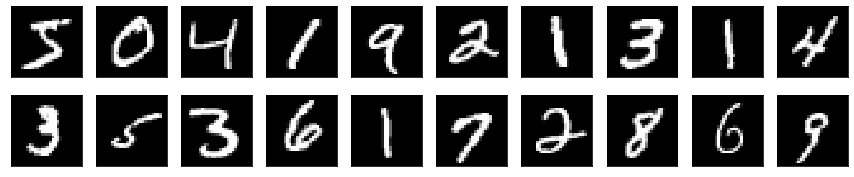

In [4]:
print(train_loader.dataset.targets.shape)
print(train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension is {}.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

Two network moduls are defined. Both have 3 hidden layers with the same size of neurons. The only difference is the activation functions. The sigmoid activation function will cause the gradients to vanish.

In [5]:
class ANN_sigmoid(nn.Module):
    def __init__(self, D_in, D_out):
        super(ANN_sigmoid, self).__init__()
        self.linear1 = nn.Linear(D_in, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, D_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        x = self.linear4(x)
        return F.log_softmax(x, dim=1)
    
    
class ANN_relu(nn.Module):
    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, D_out)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return F.log_softmax(x, dim=1)

In [6]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    grads1_list = []
    grads2_list = []
    grads3_list = []
    grads4_list = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, input_dim))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        
        # This part of the code gets the weights in the different layers
        grads4 = abs(model.linear4.weight.grad)
        grads3 = abs(model.linear3.weight.grad)
        grads2 = abs(model.linear2.weight.grad)
        grads1 = abs(model.linear1.weight.grad)
        grads4_list.append(torch.sum(grads4).item())
        grads3_list.append(torch.sum(grads3).item())
        grads2_list.append(torch.sum(grads2).item())
        grads1_list.append(torch.sum(grads1).item())
        
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return grads1_list, grads2_list, grads3_list, grads4_list

In [7]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = Variable(data.view(-1, input_dim))
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))    

In [8]:
print("output_dim: {0}".format(output_dim))

output_dim: 10


<<<<<<< SIGMOID <<<<<<<
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.344907
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.298969
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.309132
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.311139
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.301283
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.312292
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.288453
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.299210
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.327736
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.307887


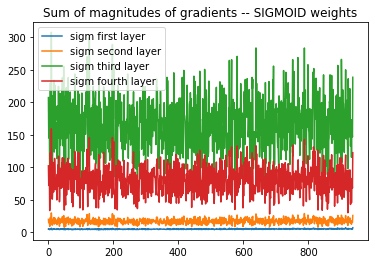


Test set: Average loss: 2.2990, Accuracy: 1032/10000 (10.32%)



In [9]:
# Main
print("<<<<<<< SIGMOID <<<<<<<")
model = ANN_sigmoid(input_dim, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    grads1_list, grads2_list, grads3_list, grads4_list = train(args, model, device, train_loader, optimizer, epoch)
    plt.plot(np.array(grads1_list))
    plt.plot(np.array(grads2_list))
    plt.plot(np.array(grads3_list))
    plt.plot(np.array(grads4_list))
    plt.title('Sum of magnitudes of gradients -- SIGMOID weights')
    plt.legend(("sigm first layer", "sigm second layer", "sigm third layer","sigm fourth layer"))
    plt.show()
  
    test(args, model, device, test_loader)

del model    


<<<<<<< RELU <<<<<<<
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304874
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.834448
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.542285
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.413058
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.301880
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.376588
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.221894
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.217881
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.432468
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.207029


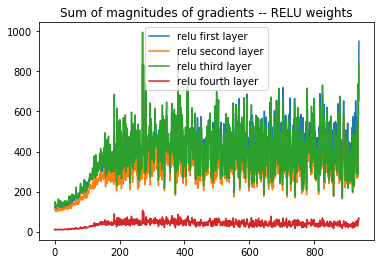


Test set: Average loss: 0.2809, Accuracy: 9164/10000 (91.64%)



In [10]:
print("<<<<<<< RELU <<<<<<<")
model = ANN_relu(input_dim, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    grads1_list, grads2_list, grads3_list, grads4_list = train(args, model, device, train_loader, optimizer, epoch)
    plt.plot(np.array(grads1_list))
    plt.plot(np.array(grads2_list))
    plt.plot(np.array(grads3_list))
    plt.plot(np.array(grads4_list))
    plt.title('Sum of magnitudes of gradients -- RELU weights')
    plt.legend(("relu first layer", "relu second layer", "relu third layer","relu fourth layer"))
    plt.show()
    
    test(args, model, device, test_loader)

In [11]:
60000/64

937.5